<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

## Simulate the runout extent, sediment transport and topographic change caused by the runout of a rectangular landslide over a synthetic terrain using MassWastingRunout

#### In this tutorial, the user defines the rectangular geometry of a landslide, parameterizes MassWastingRunout (MWR) and chooses one of 6 synthetic terrains on which the runout of the landslide is modeled.

#### Model overview
- MWR models the downslope progression of mass wasting processes such as debris flows or dry debris avalanches.

- Mass continuity is central to model conceptualization; at any node, the incoming flux (q_I), erosion (E) and aggradation (A) determine outgoing flux (q_O) and ultimately the runout extent and how the landscape evolves. 

<div>    
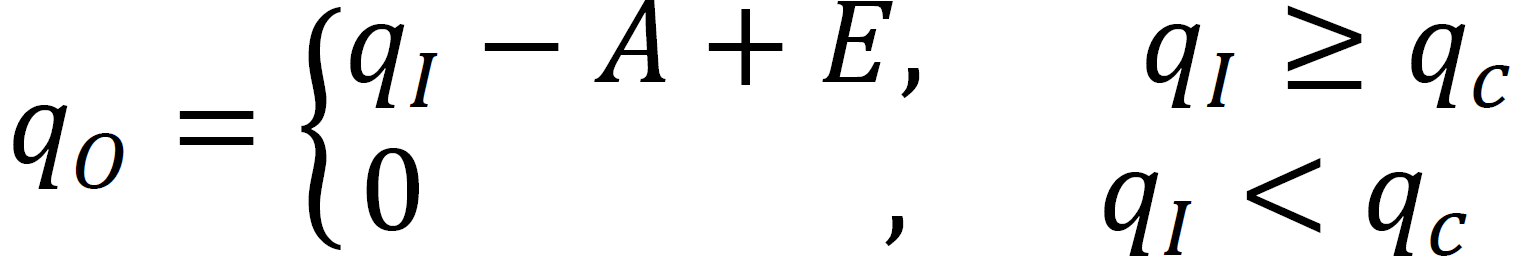
<div>
    
    
- MWR uses a set of rules and algorithms to numerically represent the release of the mass wasting source material and erosion, deposition and vegetation/debris impacts on the runout process as illustrated below:

<div>
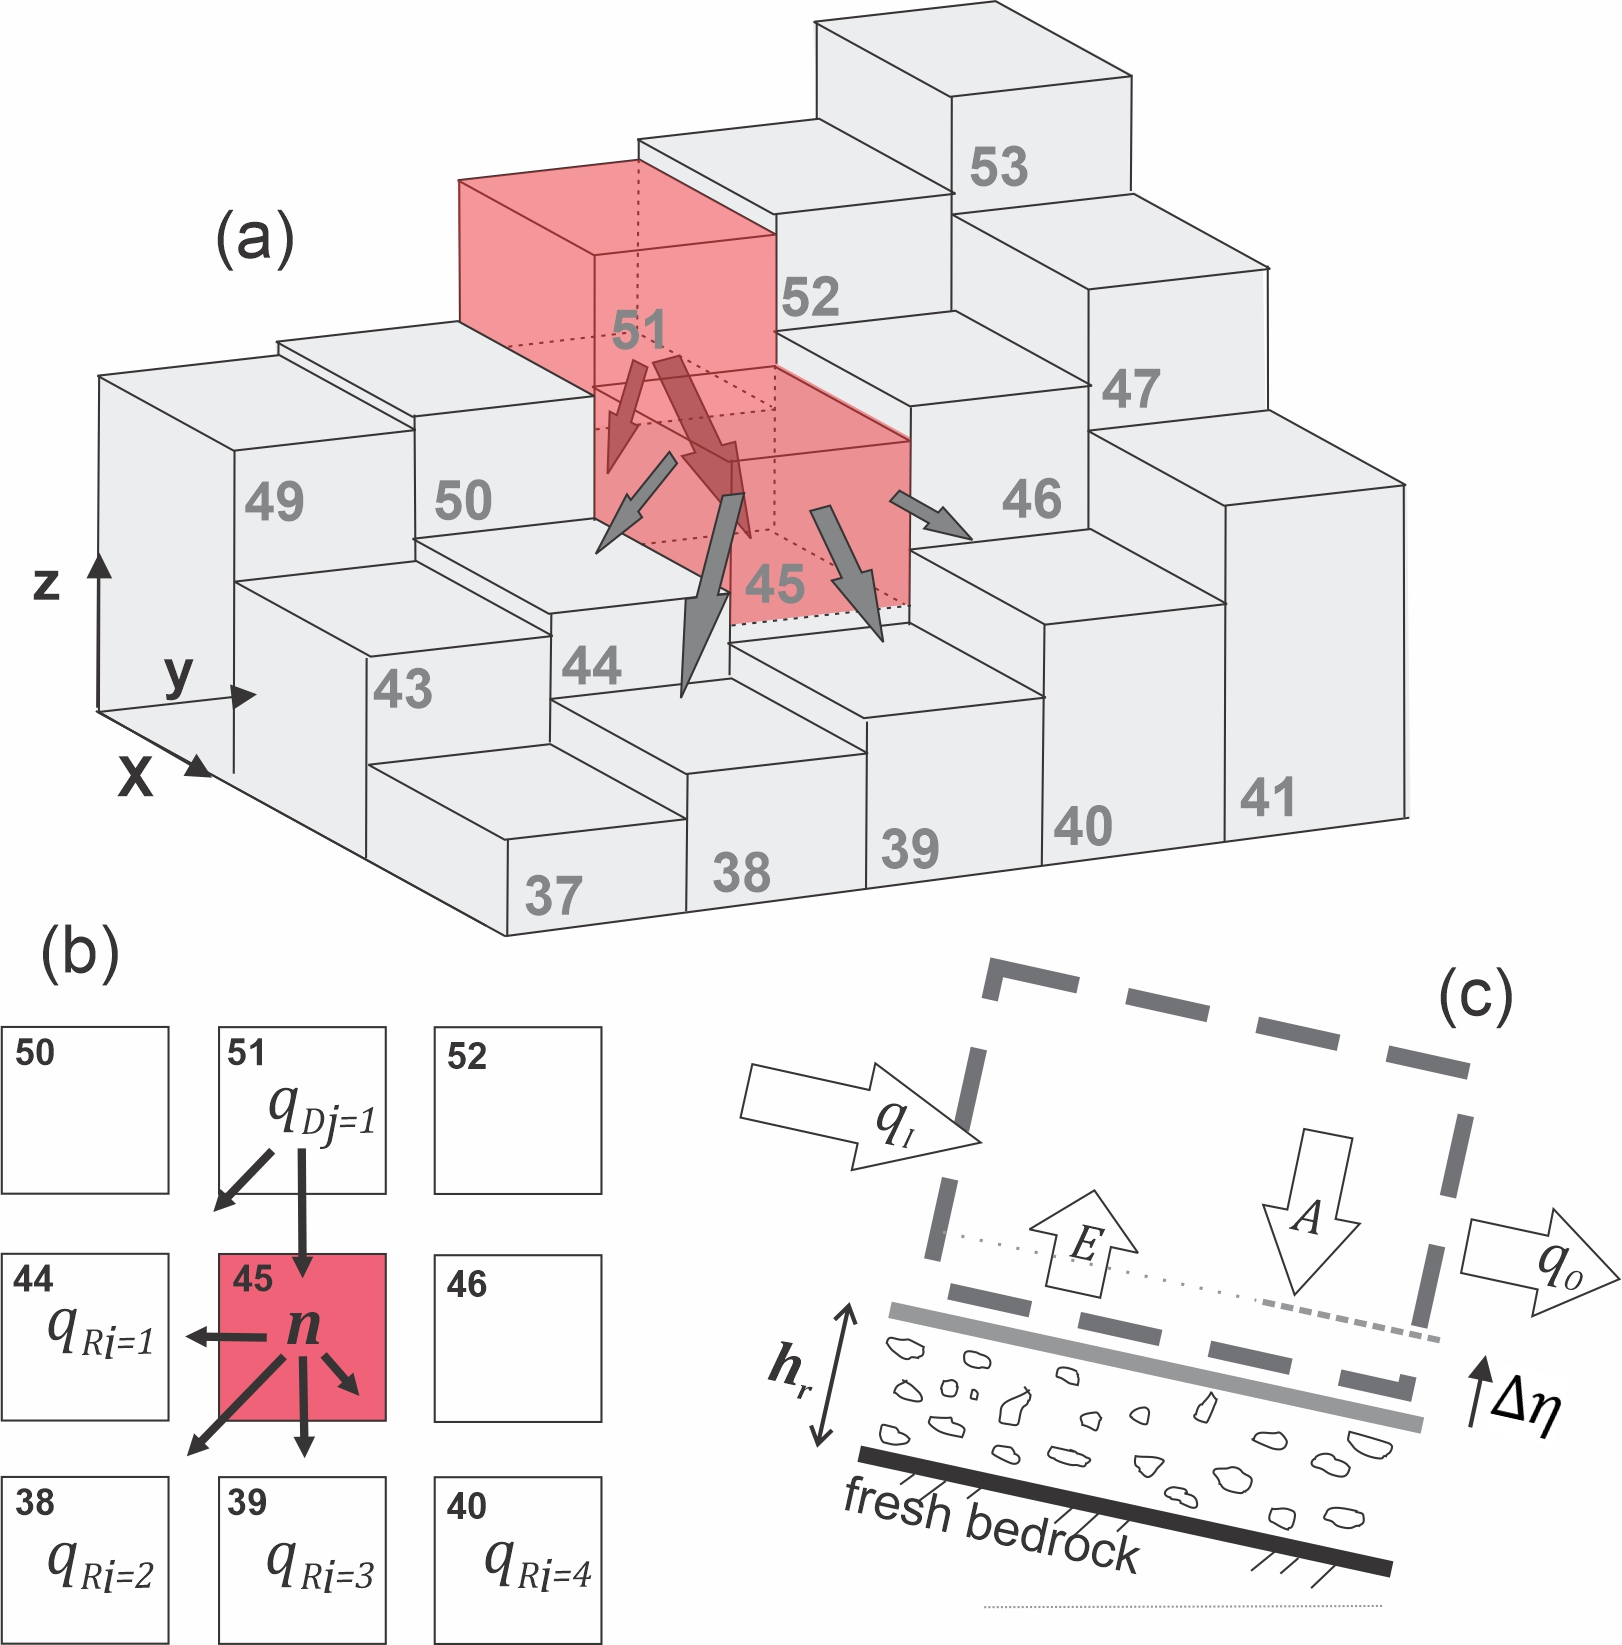
<div>                                                         

<strong><em>(a)</em></strong> Release of the initial mass wasting source material nodes (represented by red cells); <strong><em>(b)</em></strong> How q_O at node n (n = 45) is distributed downslope after incoming material q_I (here equal to flux from node 51) has aggraded (A) or eroded (E) node n; <strong><em>(c)</em></strong> Mass continuity determines the change in regolith thickness/topographic elevation. For a full description of the above parameters, see Keck et al. (2024).  

#### To begin, first import  packages and components necessary to load MWR inputs, run MWR and visualize model results.

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from landlab.components import FlowDirectorMFD
from landlab.components.mass_wasting_runout.mass_wasting_runout import MassWastingRunout
from landlab.io import read_esri_ascii

#### Next, define the mass wasting source area (landslide) geometry. <br>
In this notebook, we define the geometry of the landslide as a rectangular prism. In later notebooks, we will use the geometry of a landslide body observed in the field.

In [ ]:
ls_width = 3  # number of cells wide, must be odd number
ls_length = 5  # number of cells long
ls_h = 3  # thickness, m
soil_thickness = 2  # thickness of soil (regolith) covering synthetic terrain, m

#### Then, define key MWR parameters S_c, q_c and k.<br>
In MWR, S_c is a critical slope constraint. For some flows, it may be possible to approximate S_c from the surface slope of observed deposits. The parameter q_c is the threshold flux for deposition, that conceptually represents the flow depth below which flow resistance is large enough to cease the forward momentum of the flow, whether in the form of frictional resistance along the base of the flow or debris and vegetation in the path of the flow. Parameter k scales the erosion rate.<br> We also specify the typical particle diameter found in the regolith because in this example, we will use an erosion rule that varies as a function of the flow grain size.

In [ ]:
q_c = 0.2  # threshold flux, m
S_c = 0.03  # critical slope
k = 0.01  # erosion coefficient
Dp = 0.2  # particle diameter, m

#### Now, pick which terrain the landslide will runout on. <br>
The planimetric curvature of each terrain ranges from divergent to steeply convergent. In profile, the terrains include concave-up, convex-up, planar and broken.<br> 
Terrains are shaded with the DEM of Difference (DoD) of previous model results using ls_width = 3, ls_length = 5, ls_h = 3, soil_thickness = 2, qs_max = ls_h, q_c = .25, S_c = 0.03, k = 0.005, and Dp = 0.2. Red indicates a positive change in the elevation of the terrain (aggradation) and blue indicates a negative change (erosion).<br>

In [ ]:
terrain_id = "E"

<div>
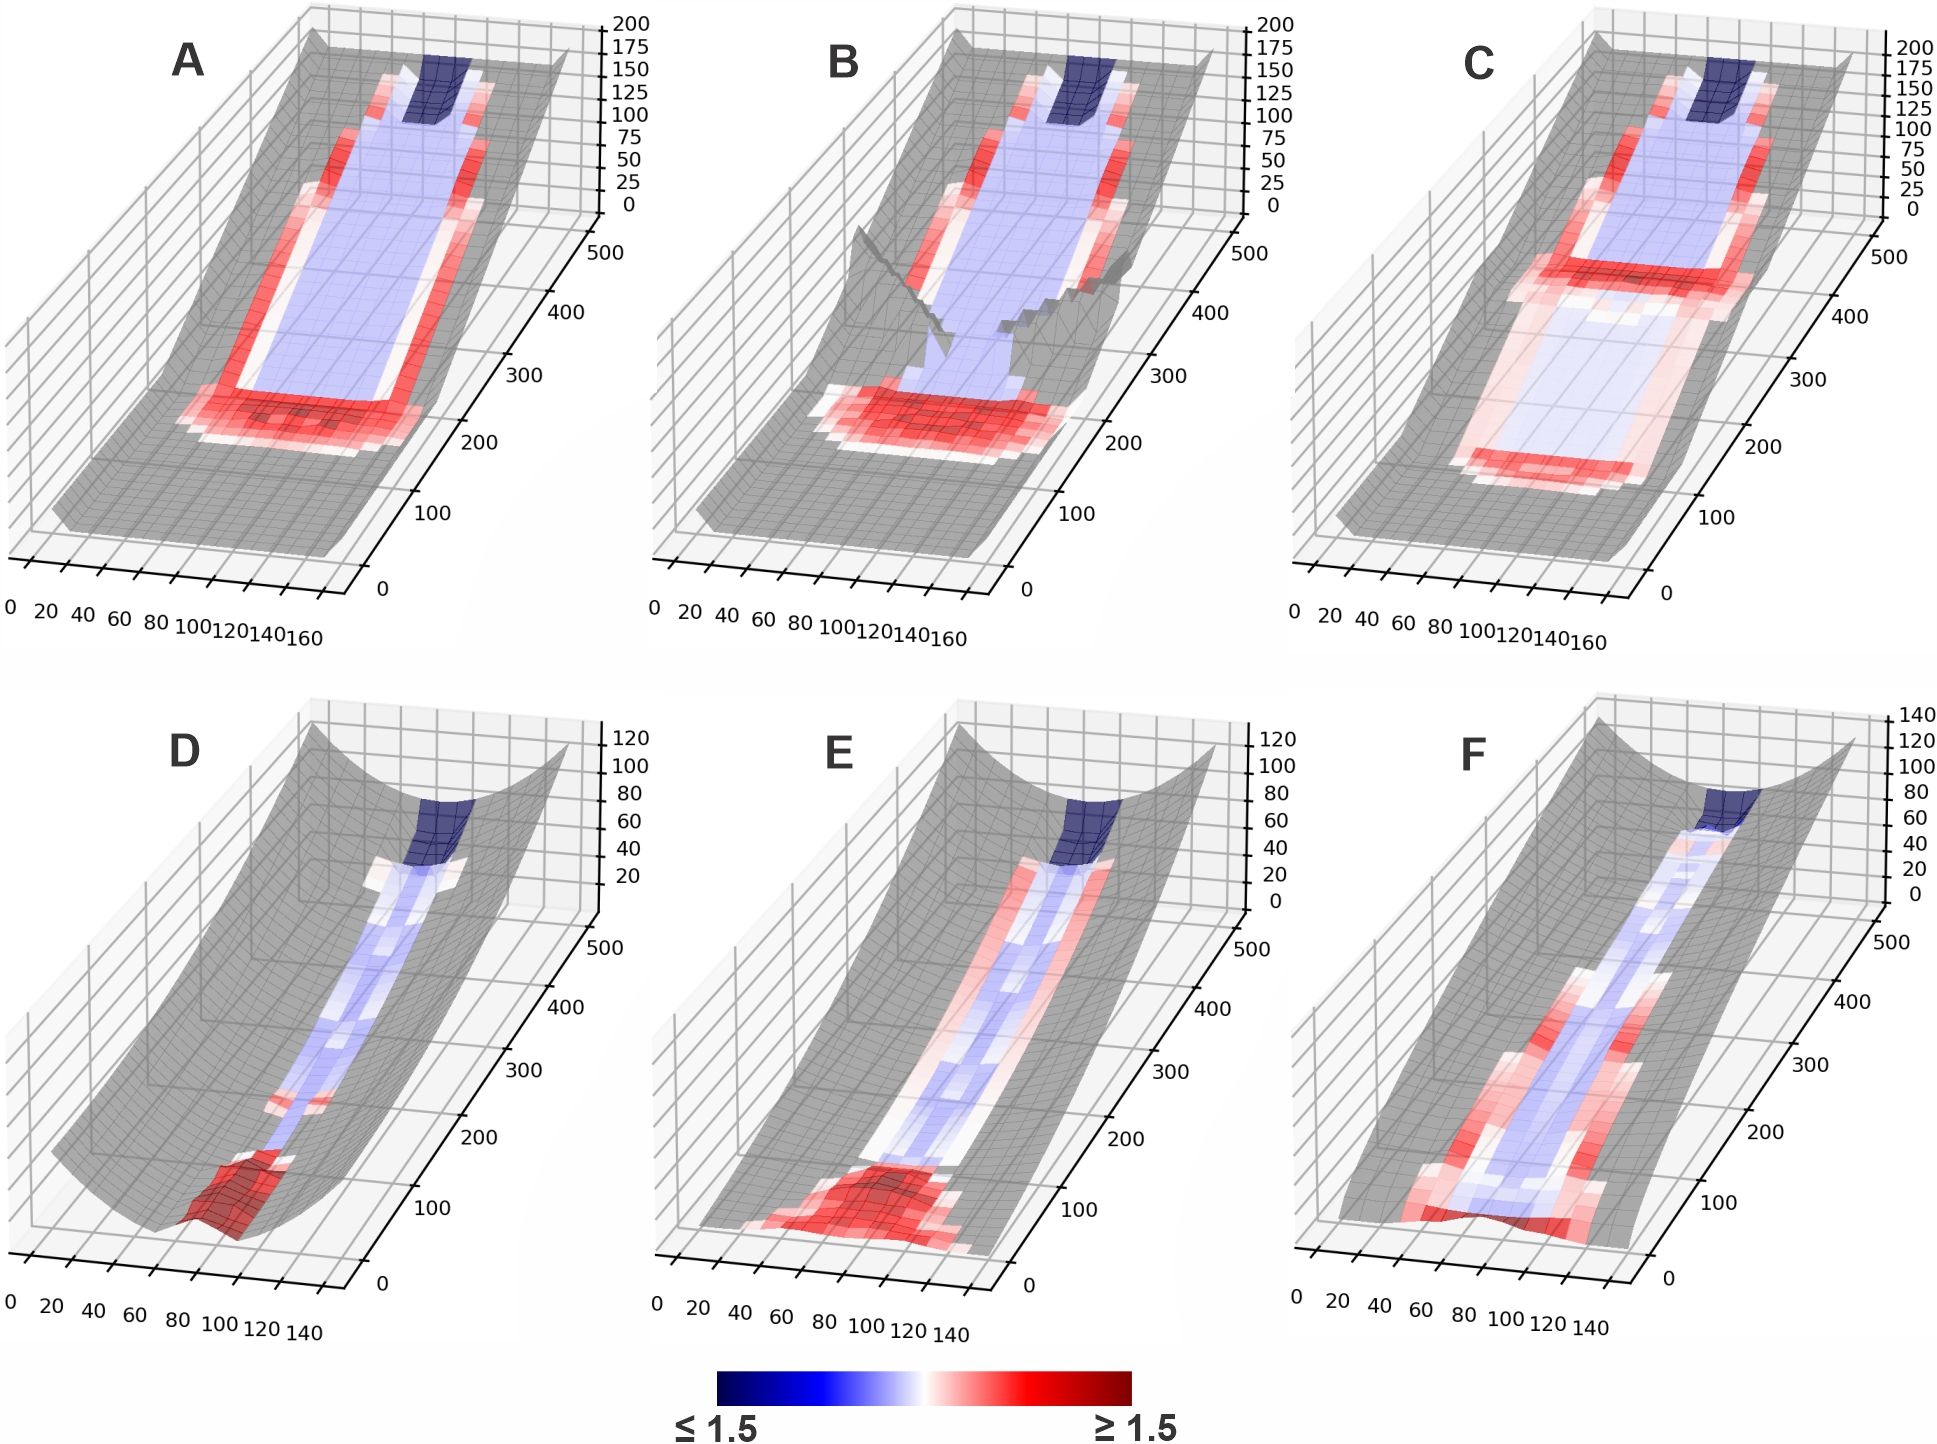
</div>    

In [ ]:
terrains = {
    "A": "A_PlanarSlope.asc",
    "B": "B_PlanarSlopeWithConstriction.asc",
    "C": "C_WideFlumeWithBench.asc",
    "D": "D_ConvergentConcave.asc",
    "E": "E_VariableConvergenceConcave.asc",
    "F": "F_VaryConvergenceConvex.asc",
}
mg, z = read_esri_ascii(terrains[terrain_id], name="topographic__elevation")

#### Now, define a few functions that will create the landslide from the given dimensions and plot model results.<br>
These functions are not necessary to run the model and are only included in this notebook for visualizing and setting up the synthetic terrains.

In [ ]:
# plotting functions, adapted from flow-director notebooks


def surf_plot(mg, surface="topographic__elevation", title="", zlim=None):
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print(f"Zmin{Z.min()}, Zmax{Z.max()}")
    color = cm.gray_r((Z - Z.min()) * 2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(
        mg.x_of_node.reshape(mg.shape),
        mg.y_of_node.reshape(mg.shape),
        Z,
        rstride=1,
        cstride=1,
        facecolors=color,
        linewidth=0.0,
        antialiased=False,
        alpha=0.67,
        shade=True,
    )
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Elevation")
    ax.view_init(elev=20, azim=-75)
    plt.title(title)
    ax.set_box_aspect([0.30, 1, 0.2])
    #     if zlim:
    #         ax.set_zlim(zlim)
    ax.tick_params(axis="both", which="major", labelsize=7)
    return surf


def surf_plot_drape(
    mg,
    surface="topographic__elevation",
    shading="dem_dif_o",
    title="",
    clim=[-1, 1],
    cmtype="diverging",
    zlim=None,
    colorbar=False,
):
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    S = mg.at_node[shading].reshape(mg.shape)
    # normalize colormap values (0 to 1) so that centered at mid point
    # between clim[0] (min) and clim[1] (max) values
    S_ = S.copy()
    S_[S > clim[1]] = clim[1]
    S_[S < clim[0]] = clim[0]
    ci = (S_ - clim[0]) / (clim[1] - clim[0])
    if cmtype == "diverging":
        color = cm.seismic(ci)  # cm.bwr(ci)
    elif cmtype == "sequential":
        color = cm.terrain(ci)
    color[ci == 0.5] = [
        0.50196078,
        0.50196078,
        0.50196078,
        1,
    ]  # set zero values to grey
    surf = ax.plot_surface(
        mg.x_of_node.reshape(mg.shape),
        mg.y_of_node.reshape(mg.shape),
        Z,
        rstride=1,
        cstride=1,
        facecolors=color,
        linewidth=0.0,
        antialiased=False,
        alpha=0.65,
        shade=False,
    )
    ax.view_init(elev=20, azim=-75)
    plt.title(title)
    ax.set_box_aspect([0.30, 1, 0.2])
    ax.tick_params(axis="both", which="major", labelsize=7)
    if colorbar:
        if cmtype == "diverging":
            m = cm.ScalarMappable(cmap=cm.bwr, norm=surf.norm)
        if cmtype == "sequential":
            m = cm.ScalarMappable(cmap=cm.terrain, norm=surf.norm)
        m.set_array(np.array(clim))
        plt.colorbar(m, ax=ax, shrink=0.25)
    return surf


# functions to define the landslide and select runout profile nodes
def ls_profile_nodes(c, ls_width):
    if ls_width == 1:
        cc = int(c / 2) + 1
        pf = mg.nodes[:, cc]
    elif (ls_width <= c) and (ls_width % 2 == 1):
        cc = []
        for i in range(ls_width):
            dif = -((ls_width) % 2) + i
            cc.append(int(c / 2) + dif + 1)
        cc = np.array(cc)
        pf = mg.nodes[:, int(c / 2) + 1]
    return pf, cc


def landslide_nodes(ls_length, cc):
    # landslide nodes
    lsn = mg.nodes[-(ls_length + 1) : -1, cc]
    return lsn

#### Using the selected terrain, grain size and regolith (soil) depth inputs from above, define the raster model grid. <br>
Here the landslide thickness is set equal to the regolith thickness. Alternatively, the landslide thickness at each node in the landslide could be defined by providing a numpy.array of the landslide thickness values.

In [ ]:
# set boundary conditions
mg.set_closed_boundaries_at_grid_edges(
    True, True, True, False
)  # close all boundaries except end of flume
dem = mg.at_node["topographic__elevation"]

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True, partition_method="square_root_of_slope")
fd.run_one_step()

# soil thickness
thickness = np.ones(mg.number_of_nodes) * soil_thickness
mg.add_field("node", "soil__thickness", thickness)

# set particle diameter
mg.at_node["particle__diameter"] = np.ones(len(mg.node_x)) * Dp

# define the landslide
c = mg.number_of_node_columns - 2
pf, cc = ls_profile_nodes(c, ls_width)
lsn = landslide_nodes(ls_length, cc)

# define landslide location
mg.at_node["mass__wasting_id"] = np.zeros(mg.number_of_nodes).astype(int)
mg.at_node["mass__wasting_id"][lsn] = 1

# define landslide thickness equal to the regolith thickness
mg.at_node["soil__thickness"][lsn] = ls_h

#### Lets take a look at the location of the initial landslide nodes (dark grey area) relative to the flume. <br>
Here, the flume is colored according to elevation

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
surf_plot_drape(
    mg,
    surface="topographic__elevation",
    shading="topographic__elevation",
    title="",
    clim=[
        mg.at_node["topographic__elevation"].min(),
        mg.at_node["topographic__elevation"].max(),
    ],
    cmtype="sequential",
    colorbar=True,
)
ax.scatter(
    mg.node_x[lsn],
    mg.node_y[lsn] + 1,
    mg.at_node["topographic__elevation"][lsn],
    marker=".",
    color="k",
    alpha=1,
    s=100,
)

#### Now set up an instance of MWR using the newly defined raster model grid and landslide and run the model! 

In [ ]:
# set up the model
MWRu = MassWastingRunout(
    mg,
    critical_slope=[S_c],
    threshold_flux=q_c,
    erosion_coefficient=k,
    max_flow_depth_observed_in_field=ls_h,
    tracked_attributes=["particle__diameter"],
    effective_qsi=True,
    save=True,
    grain_shear=True,
    settle_deposit=False,
)
# run the model
MWRu.run_one_step()

#### Once the model has finished running, view the runout extent and how the landslide runout modified the terrain. <br>
Here the terrain is shown following the runout of the landslide and is now colored according to the DoD. Notice how the landslide removed material at its source, and except for lateral levees, eroded over most of the runout path. The runout material deposited once the slope of the terrain << S_c. Again, red indicates a positive change in the elevation of the terrain (aggradation) and blue indicates a negative change (erosion).

In [ ]:
%matplotlib inline
clim = [-ls_h / 2, ls_h / 2]  # colorbar limits for plot, plots below use [-0.5, 0.5]
mg.at_node["dem_dif_o"] = (
    mg.at_node["topographic__elevation"] - mg.at_node["topographic__initial_elevation"]
)
# exagerate topographic change for visualization
mg.at_node["topographic__elevation_with_change"] = (
    mg.at_node["topographic__initial_elevation"] + mg.at_node["dem_dif_o"] * 3
)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
surf = surf_plot_drape(
    mg,
    surface="topographic__elevation_with_change",
    shading="dem_dif_o",
    title="",
    clim=clim,
    colorbar=True,
)

#### Finally, watch an animation of the runout process that created the final erosion and depositional pattern shown above. The runout is visualized as the DoD of each model iteration. <br>

In [ ]:
# topo with drape
clim = [-ls_h / 2, ls_h / 2]  # color bar range
%matplotlib notebook


def update_plot(frame_number, MWRu, plot):
    mg.at_node["topographic__elevation"] = (
        mg.at_node["topographic__initial_elevation"]
        + (
            MWRu.saver.runout_evo_maps[0][frame_number]
            - mg.at_node["topographic__initial_elevation"]
        )
        * 3
    )  # exagerate change in plot
    mg.at_node["dem_dif_o"] = (
        MWRu.saver.runout_evo_maps[0][frame_number]
        - mg.at_node["topographic__initial_elevation"]
    )
    plot[0].remove()
    plot[0] = surf_plot_drape(
        mg,
        surface="topographic__elevation",
        shading="dem_dif_o",
        title="iteration " + str(frame_number),
        clim=clim,
    )


fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection="3d")
nmax = len(MWRu.saver.runout_evo_maps[0].keys())
mg.at_node["topographic__elevation"] = MWRu.saver.runout_evo_maps[0][0]
mg.at_node["dem_dif_o"] = (
    MWRu.saver.runout_evo_maps[0][0] - mg.at_node["topographic__initial_elevation"]
)
plot = [
    surf_plot_drape(
        mg,
        surface="topographic__elevation",
        shading="dem_dif_o",
        title="iteration " + str(0),
        clim=clim,
        colorbar=True,
    )
]
animate = animation.FuncAnimation(
    fig, update_plot, nmax, fargs=(MWRu, plot), repeat=True
)
plt.show()

#### Now that you've seen an example, try re-running this notebook with different parameter values, terrains and landslide geometries to see how MWR responds!